In [7]:
library(pheatmap)  
library(tidyverse)
library(RColorBrewer)
library(viridis)
library(reshape2)
library(caret)

library( org.Hs.eg.db ) 
library(AnnotationDbi) 
library(Biobase)
library(limma)
library(tximport)

library(stringr)

library(Rtsne)
library(caret)  
library(clusterProfiler)
library(pheatmap)
library(ReactomePA)
library(annotate)
library(seqinr)
# library(qlcMatrix)


In [8]:
save_pheatmap_png <- function(x, filename, width=1200, height=1000, res = 200) {
  png(filename, width = width, height = height, res = res)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

In [9]:
annon_df = read.csv('../data/external/HOCOMOCOv11_annotation.csv',row.names=1)
head(annon_df)

id                   tf  
0 AHR_HUMAN.H11MO.0.B  AHR 
1 AIRE_HUMAN.H11MO.0.C AIRE
2 ALX1_HUMAN.H11MO.0.B ALX1
3 ALX3_HUMAN.H11MO.0.D ALX3
4 ALX4_HUMAN.H11MO.0.D ALX4
5 ANDR_HUMAN.H11MO.0.A AR

In [10]:
save_prefix = '../data/processed/fig3_footprinting/'

# differential expression analysis

In [5]:
# rna_files = as.array(list.files('../data/raw/rna/', pattern=('*/*.genes.results'),recursive=TRUE))
# # data.frame(file_path = rna_files)
# tissues = as.array(lapply(rna_files, function(x) strsplit(x, '/')[[1]][1]))
# sample = as.array(lapply(rna_files, function(x) strsplit(x, '/')[[1]][2]))
# sample = as.array(lapply(sample, function(x) strsplit(x, '.genes.results')[[1]][1]))

# full_path = as.array(lapply(rna_files, function(x) paste0('../data/raw/rna/',x)))
                
# rna_genes_result = data.frame("tissues" = tissues,"sample"=sample,"full_path"=full_path )  
# rownames(rna_genes_result) = rna_genes_result$sample        
# head(rna_genes_result  )                          

tissues    sample      
A431-1-CTRLi A431-CTRLi A431-1-CTRLi
A431-2-CTRLi A431-CTRLi A431-2-CTRLi
A431-1-p63i  A431-p63i  A431-1-p63i 
A431-2-p63i  A431-p63i  A431-2-p63i 
Airway-B1    Airway     Airway-B1   
Airway-B2    Airway     Airway-B2   
             full_path                                            
A431-1-CTRLi ../data/raw/rna/A431-CTRLi/A431-1-CTRLi.genes.results
A431-2-CTRLi ../data/raw/rna/A431-CTRLi/A431-2-CTRLi.genes.results
A431-1-p63i  ../data/raw/rna/A431-p63i/A431-1-p63i.genes.results  
A431-2-p63i  ../data/raw/rna/A431-p63i/A431-2-p63i.genes.results  
Airway-B1    ../data/raw/rna/Airway/Airway-B1.genes.results       
Airway-B2    ../data/raw/rna/Airway/Airway-B2.genes.results

In [6]:
# files <- file.path(full_path)
# names(files) <- rna_genes_result$sample
# txi.rsem <- tximport(files, type = "rsem", txIn = FALSE, txOut = FALSE)
### ERROR Need to make all rownames the same...

In [12]:

createSig <- function (data, metadata, col_sel,tissue=TRUE, logFC_thres=.1, p_thres=0.05,max_return = 500) {
    # Differential expression analysis with limmma
    # This function takes in a target
    # Output is a result table of differential expression analysis for target vs control

    # load data and preprocess
#     metadata_sel <- labels_df %>% 
#         filter(control==control_id)%>%
#         filter(label == target | label == "control")%>%
#         dplyr::select(-control)    
#     rownames(metadata_sel) = metadata_sel$sample
#     data <- counts_all_filt[ ,rownames(metadata_sel) ]
#     log_data <- log2(data+1) 
    
#     metadata = data.frame("column" =cols_all)
    if (tissue){
    metadata = metadata %>% 
        mutate(label = if_else(tissues==col_sel, 'target', 'control'))
    }
    else{
         metadata = metadata %>% 
        mutate(label = if_else(group==col_sel, 'target', 'control'))
    }
    
    # set up the design
    labels <- factor(metadata$label)
    design <- model.matrix(~ labels + 1)
    colnames(design) <- levels(labels)
    rownames(design) <- metadata$tissue

    # proceed with analysis
    fit <- lmFit(data, design)
    fit <- eBayes(fit, trend=TRUE)
    tT = topTable(fit, coef=ncol(design),adjust="fdr", sort.by="p", number=Inf)
    tT$gene = rownames(tT)
    tT = na.omit(tT)
    tT_filt = tT[tT$logFC>logFC_thres  & tT$adj.P.Val<p_thres,]
    tT_filt = tT_filt%>% arrange(desc(logFC))
#     print(dim(tT_filt))
    tT_filt = tT_filt[1:min(max_return, dim(tT_filt)[1]),]

  return(tT_filt)
}

In [13]:
rna_tpm_file_tissue = '../data/interim/rna/tissue_tpm_sym.csv'
rna_df_tissue = read.csv(rna_tpm_file_tissue, row.names=1,stringsAsFactors=F,check.names = FALSE)
rna_df_tissue_log = log2(rna_df_tissue+1e-2)
rna_df_tissue_norm = as.data.frame(scale(rna_df_tissue_log, center = TRUE, scale = TRUE))


In [9]:
rna_tpm_file = '../data/interim/rna/sample_tpm_sym.csv'
rna_df = read.csv(rna_tpm_file, row.names=1,stringsAsFactors=F,check.names = FALSE)
rna_df_log = log2(rna_df+1e-2)
rna_df_norm = as.data.frame(scale(rna_df_log, center = TRUE, scale = TRUE))
head(rna_df_norm)

A431-1-CTRLi A431-1-p63i A431-2-CTRLi A431-2-p63i Airway-B1 
A1BG      0.6417831    0.6623433   0.7994448    0.7303720   0.6541822
A1BG-AS1  0.2892481   -0.5210944  -0.5150074   -0.5875764  -0.5020608
A1CF     -1.0291413   -1.0467041  -1.0465532   -1.0575809  -1.0307378
A2M      -1.0291413   -0.2942805  -0.5150074   -1.0575809  -1.0307378
A2M-AS1  -1.0291413   -1.0467041  -1.0465532   -0.8551610  -1.0307378
A2ML1    -0.6083868   -0.5745781  -1.0465532   -1.0575809   0.3367865
         Airway-B2  Astrocytes-B1 Astrocytes-B2 Bladder-B1  Bladder-B2 ⋯
A1BG      0.7392987  1.1087689     1.1485692     0.65029894  0.7204134 ⋯
A1BG-AS1 -0.4581187 -0.1194657     0.1052466    -0.46525912 -1.0460320 ⋯
A1CF     -0.8255721 -0.9271780    -0.9030065    -0.71791710 -1.0460320 ⋯
A2M      -1.0288821  1.5053966     1.3031655    -0.01205829  0.5220445 ⋯
A2M-AS1  -0.5033333 -0.6538820    -0.3925620    -1.04551518 -1.0460320 ⋯
A2ML1     0.3068355 -0.5535247    -0.5740544     0.41275087  0.2953998 ⋯
         Uterine-B1  Uterine-B2 WM2664-SCR-DMSO-BR1 WM2664-SCR-DMSO-BR2
A1BG      0.61458326  0.5914140  1.5838919           1.6188556         
A1BG-AS1 -0.50740969 -0.8272739  0.1171384          -0.2481127         
A1CF     -1.04026653 -0.8272739 -1.0922663          -1.0844294         
A2M       0.23973259  0.3963941  1.3563672           1.5210301         
A2M-AS1  -1.04026653 -1.0352871 -0.5197864          -0.6093506         
A2ML1     0.07828831 -0.2655465 -1.0922663          -1.0844294         
         WM2664-SCR-PLX-BR1 WM2664-SCR-PLX-BR2 WM2664-shMITF-DMSO-BR1
A1BG      1.6918717          1.7822770          1.675711913          
A1BG-AS1 -0.2092722          0.1470238         -0.004195876          
A1CF     -1.1073494         -1.0773221         -1.090981737          
A2M       1.4110784          1.6776894          1.475314446          
A2M-AS1  -0.7832793         -0.5998701         -0.682563644          
A2ML1    -1.1073494         -1.0773221         -0.517694465          
         WM2664-shMITF-DMSO-BR2 WM2664-shMITF-PLX-BR1 WM2664-shMITF-PLX-BR2
A1BG      1.6293048              1.70953587            1.74049731          
A1BG-AS1 -0.1286889              0.02483362           -0.07187348          
A1CF     -1.1004495             -1.11086299           -1.10838445          
A2M       1.4816454              1.48087546            1.52600059          
A2M-AS1  -0.4873368             -0.40354425           -0.25155746          
A2ML1    -1.1004495             -0.35426750           -1.10838445

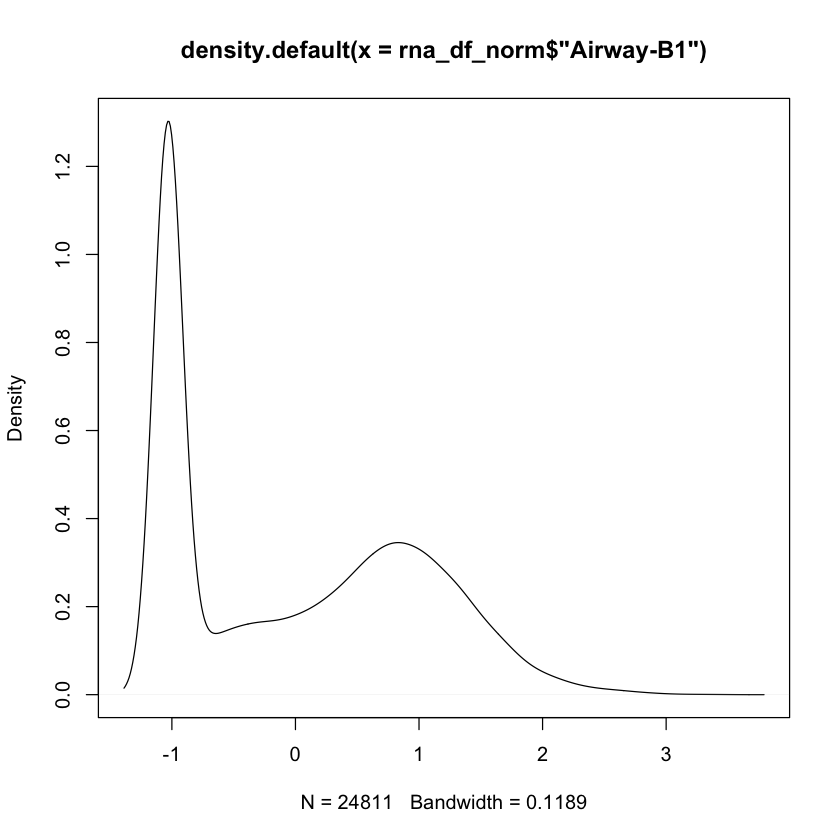

In [10]:
par (bg='white')
plot(density(rna_df_norm$"Airway-B1"))

In [11]:
# # rna_df_essential_long = gather(rna_df_norm,"tissue", "log_TPM")
# ggplot(gather(as.data.frame(rna_df_norm),"tissue", "log_TPM"), aes(x=log_TPM,color=tissue))+geom_density()

In [27]:
select_tfs = c('SOX1','PAX6','OTX2','LHX5','IRX3','POU3F2','DLK1','MAP2','CDH2',
              'EOMES','T','TBX6','SOX17','GATA4','FOXD3','SNAI1','SNAI2','NANOG','POU5F1',
              'SMAD7','ID1','LEFTY2','ATF3','FOS','FOSB','EGR1','EGR2','EGR3')
select_tf_types = c('Neural','Neural','Neural','Neural','Neural','Neural','Neural','Neural','Neural',
              'Mesoderm','Mesoderm','Mesoderm','Endoderm','Endoderm','Neural Crest','Neural Crest','Neural Crest','Pluripotent','Pluripotent',
              'Nodal','Nodal','Nodal','Early','Early','Early','Early','Early','Early')
annon_df = data.frame(type=select_tf_types)
rownames(annon_df) = select_tfs

Astrocytes  SL_D0        SL_D2       SLC_D0     SLC_D2      H9_D0      
SOX1    0.32266109  0.466451663  0.42039229  0.3466177  0.95612662 -0.73684123
PAX6    1.40136539  1.019241836  0.92560290 -0.3838150  0.58413686 -0.41731086
OTX2    0.78091611  1.481865308  1.42015379 -1.3586250 -0.16584534  0.83311365
LHX5   -1.06575329  0.922730980  0.80242949 -0.9265350  0.29199023 -0.78764216
IRX3    0.99490035  0.626091889  0.38642447  0.8973983  0.99361315 -0.06405374
POU3F2  1.20960565  0.417846238  0.99185709  0.7258434  1.33720514 -0.57364333
DLK1    1.81848589  2.255782349  1.83928599  1.2139155  0.89603046  0.30421594
MAP2    1.06795073  1.137068161  1.22558238  0.7870032  1.17670480 -0.21240849
CDH2    1.68635357  1.424210878  1.45909092  1.3346520  1.43853605  0.86915829
EOMES  -0.33176870 -1.375713323 -0.35547089 -1.1089491 -0.94717832 -0.70725539
T      -1.06575329 -0.852311408 -1.12176418  0.3221260 -0.51732760 -0.48860117
TBX6   -0.79510197  0.221595464 -0.57673735  0.1294315 -0.38834889  0.14638903
SOX17   0.12586912 -1.375713323 -1.00169713 -1.3586250 -1.14905412 -1.40234926
GATA4  -0.86101347 -1.108049983 -0.37861718 -0.8843670 -0.63334445 -0.27378910
FOXD3  -0.49097594 -1.009761002  0.01645218 -1.0696010  0.61843008  0.72083754
SNAI1   1.04173027  0.728300482  0.78402520  0.7016671  0.58099236  0.76460376
SNAI2   0.95667710  0.315627668  1.02026227  0.7563241  1.14654998 -0.13001757
NANOG  -1.06575329 -0.750565391 -1.12176418 -0.8306417 -1.11475038  1.36550595
POU5F1 -0.84063455  0.669197570 -0.03388211  0.8508178 -0.10537136  2.25837186
SMAD7   0.06191161 -0.006637811  0.83041760  0.1764702  0.82332313  0.95071177
ID1     1.78578906  1.076345213  1.57669660  0.8546578  1.66080876  1.34103879
LEFTY2 -0.51286574 -1.375713323  0.56207226 -1.0696010 -0.23270779  0.94864020
ATF3    1.19659074  0.874921000  1.01718940  1.0407074  0.95328544  0.80669286
FOS     1.05887495  0.299088374  0.33363242 -0.2220077  0.33581328  0.33928927
FOSB    0.88729239 -0.014828521 -0.05814872 -0.5541590 -0.02234478 -0.17525360
EGR1    1.84490315  0.643319828  0.92949141  0.1683070  1.08998824  0.15336315
EGR2    0.08077187 -0.407585999 -0.01495880 -0.3947979  0.17377121 -0.09787477
EGR3    0.16268564 -0.309297018 -0.23763873 -0.8306417  0.05529337 -0.69350353
       H9_D2       H9_D10     H9_D28     
SOX1   -0.24050806  0.1314755  0.83125009
PAX6   -0.28815458  0.4283879  0.75999974
OTX2    1.20366228  1.1631064  0.58591718
LHX5    0.25760853  0.6226210  0.75788047
IRX3    0.27579421  0.6246244  0.88953377
POU3F2  1.02976795  1.2907500  1.11683860
DLK1    0.84052557  1.4543302 -0.05459416
MAP2    0.76652673  1.3626209  1.67275834
CDH2    1.11138398  1.4428025  1.29826382
EOMES  -0.49124327 -0.1267552 -1.39733866
T      -0.71764980 -0.5882759 -1.39733866
TBX6    0.06069296 -0.1639798 -0.51205546
SOX17  -0.93271891 -1.4874070 -1.39733866
GATA4  -0.29986120 -0.4155968 -1.39733866
FOXD3   0.41604506 -0.8573332  0.12935592
SNAI1   0.97483918  0.5950157 -0.01294039
SNAI2   0.85528569  1.0276840  0.22719883
NANOG   0.93469254 -0.2134370 -1.39733866
POU5F1  1.97299932  0.6398228 -1.39733866
SMAD7   0.72325032  0.6062625  0.67281726
ID1     1.70069114  1.2261607  0.78573670
LEFTY2  0.33035825  0.1940418 -0.29400890
ATF3    0.70043908  1.2694564  0.20554798
FOS     0.18211259  0.4437975  0.07787090
FOSB   -0.29787794  0.1201070 -0.58456029
EGR1    0.76213640  0.4616431 -0.04036200
EGR2   -0.40068991 -0.2732390 -0.47924565
EGR3   -0.27141296 -0.7518848 -0.47924565

pdf 
  2

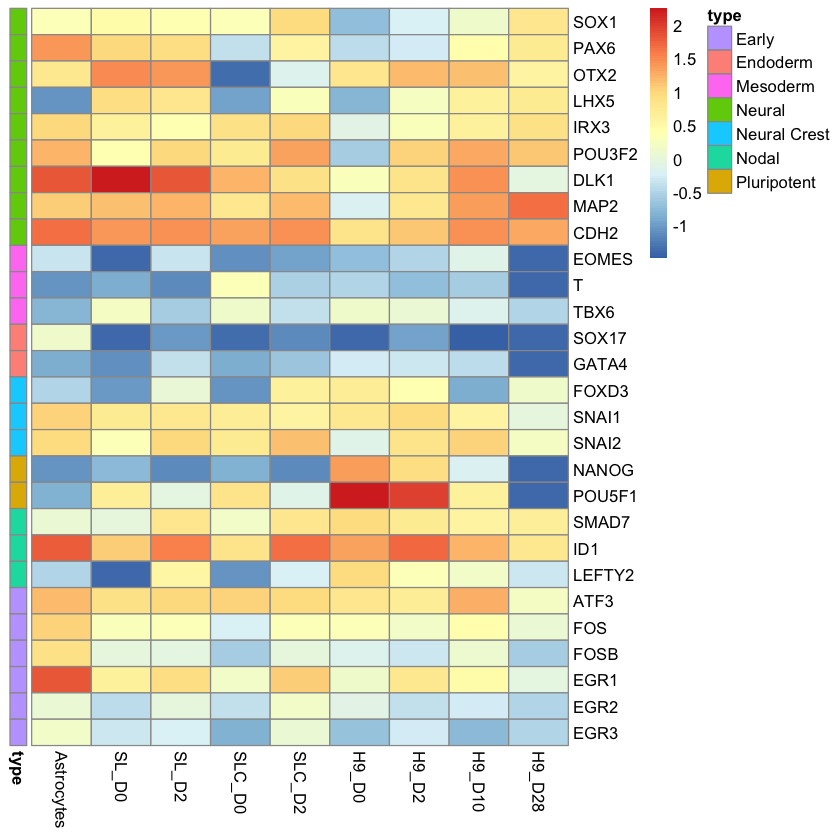

In [42]:
rna_df_sel = rna_df_tissue_norm[select_tfs,]
# rna_df_sel[rna_df_sel>5]=5

# rna_df_sel[rna_df_sel< -5]=-5
rna_df_sel
p = expr_tf_sel = pheatmap(rna_df_sel,
         cluster_row=F,
         cluster_col=F,
        annotation_row=annon_df)
save_pheatmap_pdf(p, paste0(save_prefix, 'tf_expr_heatmap_lognorm.pdf'), width=8, height=7) 


In [12]:
normal_tissues = c('Airway','Astrocytes','Bladder','Colon','Esophageal',
'GDSD0',
'GDSD3',
'GDSD6',
'GM12878',
'HMEC',
'Melanocytes',
'Ovarian',
'Pancreas',
'Prostate',
'Renal',
'Thyroid',
'Uterine')



In [13]:
rna_df_tissue_tf_normal = rna_df_tissue[as.character(annon_df$tf),normal_tissues]
rna_df_tissue_tf_normal_bin = rna_df_tissue_tf_normal
rna_df_tissue_tf_normal_bin[rna_df_tissue_tf_normal<=5]<-0
rna_df_tissue_tf_normal_bin[rna_df_tissue_tf_normal>5]<-1


In [14]:
TF_unique_tissue = rownames(rna_df_tissue_tf_normal_bin)[rowSums(rna_df_tissue_tf_normal_bin)==1]
TF_unique_tissue = na.omit(TF_unique_tissue)
length(TF_unique_tissue)

[1] 30

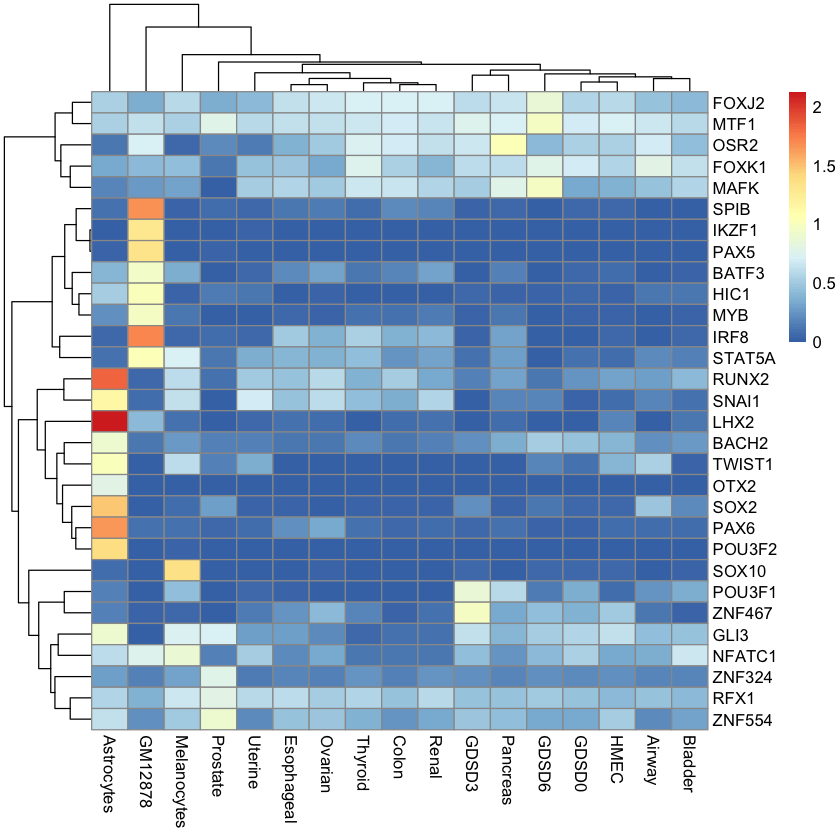

In [15]:
pheatmap(log10(rna_df_tissue[TF_unique_tissue,normal_tissues]+1))

In [16]:
rna_df_tissue[TF_unique_tissue,normal_tissues]

Airway Astrocytes Bladder Colon Esophageal GDSD0 GDSD3 GDSD6 GM12878
BACH2  0.690    6.850    0.850   0.315 0.330      1.855 0.665 2.310  0.290 
BATF3  0.040    1.530    0.060   0.515 0.605      0.125 0.030 0.000  7.790 
FOXJ2  1.900    2.515    1.540   4.030 3.240      2.585 3.090 6.390  1.260 
FOXK1  5.130    1.160    3.165   2.525 2.000      3.835 3.095 4.935  1.640 
GLI3   1.730    6.850    1.805   0.275 0.895      2.690 3.150 2.320  0.045 
HIC1   0.330    2.310    0.295   0.050 0.040      0.125 0.130 0.075  9.095 
IKZF1  0.000    0.035    0.010   0.020 0.035      0.000 0.040 0.020 18.060 
IRF8   0.005    0.140    0.140   1.385 2.170      0.000 0.100 0.020 51.240 
LHX2   0.000  131.805    0.285   0.170 0.245      0.000 0.050 0.000  1.615 
MAFK   1.905    0.505    2.655   3.525 2.665      1.095 2.390 8.355  0.810 
MTF1   3.615    2.455    2.895   3.925 3.285      3.860 4.625 8.275  3.165 
MYB    0.025    0.675    0.060   0.245 0.130      0.070 0.070 0.030  8.260 
NFATC1 1.295    2.970    3.615   0.295 0.580      2.490 1.720 1.600  4.685 
OSR2   3.845    0.300    1.730   3.985 1.370      2.510 3.660 1.595  4.125 
OTX2   0.000    5.180    0.025   0.000 0.010      0.000 0.005 0.010  0.005 
PAX5   0.000    0.100    0.030   0.035 0.035      0.000 0.040 0.000 19.750 
PAX6   0.215   42.395    0.205   0.140 0.710      0.100 0.110 0.055  0.250 
POU3F1 0.720    0.450    1.195   0.030 0.065      1.275 6.190 0.390  0.050 
POU3F2 0.015   22.145    0.045   0.030 0.025      0.000 0.010 0.000  0.015 
RFX1   1.845    2.650    1.540   1.880 2.935      1.820 1.800 2.090  1.360 
RUNX2  0.935   66.055    1.645   2.275 1.905      0.750 0.475 0.280  0.155 
SNAI1  0.540   12.540    0.240   1.260 1.820      0.060 0.050 0.505  0.190 
SOX10  0.000    0.160    0.075   0.030 0.010      0.115 0.140 0.140  0.025 
SOX2   1.995   28.815    0.585   0.065 0.060      0.150 0.680 0.325  0.020 
SPIB   0.000    0.220    0.045   0.555 0.300      0.120 0.065 0.020 46.390 
STAT5A 0.625    0.250    0.460   0.775 1.490      0.230 0.250 0.045  9.560 
TWIST1 2.470    9.220    0.065   0.015 0.030      0.225 0.030 0.505  0.015 
ZNF324 0.505    0.900    0.495   0.435 0.525      0.560 0.640 0.675  0.445 
ZNF467 0.325    0.445    0.070   0.065 0.790      1.380 8.225 1.665  0.090 
ZNF554 0.570    3.285    0.990   0.760 1.885      1.095 1.995 1.130  0.680 
       HMEC  Melanocytes Ovarian Pancreas Prostate Renal Thyroid Uterine
BACH2  1.465  0.815      0.285   1.245    0.475    0.430 0.580   0.440  
BATF3  0.170  1.285      1.060   0.470    0.000    1.050 0.325   0.115  
FOXJ2  2.875  2.780      3.655   3.335    1.290    4.020 4.145   1.540  
FOXK1  2.635  1.670      1.185   3.025    0.290    1.420 4.690   1.920  
GLI3   3.325  4.345      0.580   1.450    4.225    0.245 0.110   0.935  
HIC1   0.080  0.100      0.065   0.065    0.380    0.040 0.040   0.295  
IKZF1  0.015  0.010      0.035   0.030    0.030    0.025 0.000   0.055  
IRF8   0.115  0.115      1.365   0.985    0.215    1.640 2.515   0.125  
LHX2   0.480  0.275      0.205   0.205    0.050    0.270 0.040   0.155  
MAFK   1.315  1.050      2.205   4.830    0.000    2.630 3.730   2.340  
MTF1   4.145  2.435      3.260   4.120    4.860    3.405 3.695   2.760  
MYB    0.080  0.280      0.100   0.330    0.015    0.390 0.265   0.035  
NFATC1 1.165  6.785      1.155   0.755    0.450    0.315 0.325   2.275  
OSR2   2.530  0.110      2.170   9.635    0.630    3.190 4.470   0.370  
OTX2   0.000  0.000      0.000   0.000    0.000    0.010 0.000   0.000  
PAX5   0.035  0.025      0.030   0.045    0.100    0.045 0.000   0.045  
PAX6   0.165  0.240      1.155   0.230    0.155    0.200 0.225   0.185  
POU3F1 0.215  1.660      0.030   2.895    0.025    0.035 0.015   0.130  
POU3F2 0.050  0.100      0.025   0.025    0.005    0.030 0.000   0.035  
RFX1   1.640  3.640      2.250   1.850    5.350    2.890 2.670   2.850  
RUNX2  1.030  3.090      2.885   1.040    0.230    1.170 1.405   2.170  
SNAI1  0.200  3.170      3.060   0.505    0.0

In [17]:
rna_genes_result_normal = rna_genes_result[rna_genes_result$tissues %in% normal_tissues,]
normal_samples = as.array(rna_genes_result_normal$sample)

- grey: 'GM12878'
- purple: 'GDSD0','GDSD3','GDSD6','Airway','Prostate','Breast','Bladder','Uterine'
- green: 'Renal', 'Colon', 'Ovarian', 'Thyroid', 'Esophageal','Pancreas'
- blue: 'Astrocytes', 'Melanocytes'

In [18]:
rna_genes_result_normal$group = c("purple","purple","blue","blue","purple","purple","green","green","green","green",
                                 "purple","purple","purple","purple","purple","purple",
                                 "grey","grey","purple","purple","blue","blue",
                                 "green","green","green","green","purple","purple",
                                 "green","green","green","green","purple","purple")
rna_genes_result_normal

tissues     sample        
Airway-B1      Airway      Airway-B1     
Airway-B2      Airway      Airway-B2     
Astrocytes-B1  Astrocytes  Astrocytes-B1 
Astrocytes-B2  Astrocytes  Astrocytes-B2 
Bladder-B1     Bladder     Bladder-B1    
Bladder-B2     Bladder     Bladder-B2    
Colon-B1       Colon       Colon-B1      
Colon-B2       Colon       Colon-B2      
Esophageal-B1  Esophageal  Esophageal-B1 
Esophageal-B2  Esophageal  Esophageal-B2 
GDSD0-B1       GDSD0       GDSD0-B1      
GDSD0-B2       GDSD0       GDSD0-B2      
GDSD3-B1       GDSD3       GDSD3-B1      
GDSD3-B2       GDSD3       GDSD3-B2      
GDSD6-B1       GDSD6       GDSD6-B1      
GDSD6-B2       GDSD6       GDSD6-B2      
GM12878-B1     GM12878     GM12878-B1    
GM12878-B2     GM12878     GM12878-B2    
HMEC-B1        HMEC        HMEC-B1       
HMEC-B2        HMEC        HMEC-B2       
Melanocytes-B1 Melanocytes Melanocytes-B1
Melanocytes-B2 Melanocytes Melanocytes-B2
Ovarian-B1     Ovarian     Ovarian-B1    
Ovarian-B2     Ovarian     Ovarian-B2    
Pancreas-B1    Pancreas    Pancreas-B1   
Pancreas-B2    Pancreas    Pancreas-B2   
Prostate-B1    Prostate    Prostate-B1   
Prostate-B2    Prostate    Prostate-B2   
Renal-B1       Renal       Renal-B1      
Renal-B2       Renal       Renal-B2      
Thyroid-B1     Thyroid     Thyroid-B1    
Thyroid-B2     Thyroid     Thyroid-B2    
Uterine-B1     Uterine     Uterine-B1    
Uterine-B2     Uterine     Uterine-B2    
               full_path                                                group 
Airway-B1      ../data/raw/rna/Airway/Airway-B1.genes.results           purple
Airway-B2      ../data/raw/rna/Airway/Airway-B2.genes.results           purple
Astrocytes-B1  ../data/raw/rna/Astrocytes/Astrocytes-B1.genes.results   blue  
Astrocytes-B2  ../data/raw/rna/Astrocytes/Astrocytes-B2.genes.results   blue  
Bladder-B1     ../data/raw/rna/Bladder/Bladder-B1.genes.results         purple
Bladder-B2     ../data/raw/rna/Bladder/Bladder-B2.genes.results         purple
Colon-B1       ../data/raw/rna/Colon/Colon-B1.genes.results             green 
Colon-B2       ../data/raw/rna/Colon/Colon-B2.genes.results             green 
Esophageal-B1  ../data/raw/rna/Esophageal/Esophageal-B1.genes.results   green 
Esophageal-B2  ../data/raw/rna/Esophageal/Esophageal-B2.genes.results   green 
GDSD0-B1       ../data/raw/rna/GDSD0/GDSD0-B1.genes.results             purple
GDSD0-B2       ../data/raw/rna/GDSD0/GDSD0-B2.genes.results             purple
GDSD3-B1       ../data/raw/rna/GDSD3/GDSD3-B1.genes.results             purple
GDSD3-B2       ../data/raw/rna/GDSD3/GDSD3-B2.genes.results             purple
GDSD6-B1       ../data/raw/rna/GDSD6/GDSD6-B1.genes.results             purple
GDSD6-B2       ../data/raw/rna/GDSD6/GDSD6-B2.genes.results             purple
GM12878-B1     ../data/raw/rna/GM12878/GM12878-B1.genes.results         grey  
GM12878-B2     ../data/raw/rna/GM12878/GM12878-B2.genes.results         grey  
HMEC-B1        ../data/raw/rna/HMEC/HMEC-B1.genes.results               purple
HMEC-B2        ../data/raw/rna/HMEC/HMEC-B2.genes.results               purple
Melanocytes-B1 ../data/raw/rna/Melanocytes/Melanocytes-B1.genes.results blue  
Melanocytes-B2 ../data/raw/rna/Melanocytes/Melanocytes-B2.genes.results blue  
Ovarian-B1     ../data/raw/rna/Ovarian/Ovarian-B1.genes.results         green 
Ovarian-B2     ../data/raw/rna/Ovarian/Ovarian-B2.genes.results         green 
Pancreas-B1    ../data/raw/rna/Pancreas/Pancreas-B1.genes.results       green 
Pancreas-B2    ../data/raw/rna/Pancreas/Pancreas-B2.genes.results       green 
Prostate-B1    ../data/raw/rna/Prostate/Prostate-B1.genes.results       purple
Prostate-B2    ../data/raw/rna/Prostate/Prostate-B2.genes.results       purple
Renal-B1       ../data/raw/rna/Renal/Renal-B1.genes.results             green 
Renal-B2       ../data/raw/rna/Renal/Renal-B2.genes.results             green 
Thyroid-B1     ../data/raw/rna/Thyroid/Thyroid-B1.genes.results         green 
Thyroid-B2     ..

In [19]:
rna_normal_tf = rna_df_log[as.character(annon_df$tf),colnames(rna_df_log) %in% normal_samples]
# rna_normal = rna_df_norm[,colnames(rna_df_norm) %in% normal_samples]

dim(rna_normal_tf)
rna_normal_tf = na.omit(rna_normal_tf)
dim(rna_normal_tf)


[1] 401  34

[1] 398  34

In [20]:
#### per tissue


# sig_genes_list = list()
# sig_genes_combined = c()
# for (t in normal_tissues){
#     tT_filt = createSig(rna_normal_tf, rna_genes_result_normal,  col_sel=t,tissue=TRUE,logFC_thres=.1, p_thres=0.05,max_return = 10)
#     print(t)
#     print('**')
#     print(dim(tT_filt))
#     sig_genes_list[[t]] = tT_filt$gene
#     sig_genes_combined = c(sig_genes_combined,tT_filt$gene)
# }

#### per group


sig_genes_list = list()
sig_genes_combined = c()
for (group in c("grey","blue","green","purple")){
    tT_filt = createSig(rna_normal_tf, rna_genes_result_normal,  col_sel=group,tissue=FALSE,max_return = 70)
    print(group)
    print(dim(tT_filt))
    sig_genes_list[[group]] = tT_filt$gene
    sig_genes_combined = c(sig_genes_combined,tT_filt$gene)
}

[1] "grey"
[1] 41  7
[1] "blue"
[1] 44  7
[1] "green"
[1] 66  7
[1] "purple"
[1] 56  7


In [21]:
length(sig_genes_combined)
# sig_genes_combined = unique(sort(sig_genes_combined))
sig_genes_combined = unique(sig_genes_combined)
length(sig_genes_combined)

[1] 207

[1] 196

In [22]:
normal_tissue_order = c('GM12878',
                        'Astrocytes', 'Melanocytes',
                         'Colon',  'Esophageal','Ovarian', 'Pancreas','Renal','Thyroid',
                        'Airway','Bladder','GDSD0','GDSD3','GDSD6','HMEC','Prostate','Uterine')


In [23]:
annon_df = rna_genes_result_normal%>%
    dplyr::select( tissues, group)%>%
    unique()
rownames(annon_df) = annon_df$tissues
annon_df = dplyr::select(annon_df, group)
annon_df

group 
Airway      purple
Astrocytes  blue  
Bladder     purple
Colon       green 
Esophageal  green 
GDSD0       purple
GDSD3       purple
GDSD6       purple
GM12878     grey  
HMEC        purple
Melanocytes blue  
Ovarian     green 
Pancreas    green 
Prostate    purple
Renal       green 
Thyroid     green 
Uterine     purple

In [24]:
# write.csv(annon_df, '../data/processed/fig1/annon_df.csv')

In [25]:
rna_df_tissue_norm_sig = rna_df_tissue_norm[sig_genes_combined,normal_tissue_order]
rna_df_tissue_norm_sig = na.omit(rna_df_tissue_norm_sig)
# rna_df_tissue_norm_sig = rna_df_tissue_norm[sig_genes_sel,normal_tissue_order]
dim(rna_df_tissue_norm_sig)
rna_df_tissue_norm_sig[rna_df_tissue_norm_sig>2] = 2
rna_df_tissue_norm_sig[rna_df_tissue_norm_sig< -2] = -2
# rna_df_tissue_norm_sig = rna_df_tissue_norm_sig[apply(rna_df_tissue_norm_sig,1,max)>0 ,]
# rna_df_tissue_norm_sig = rna_df_tissue_norm_sig[apply(rna_df_tissue_norm_sig,1,sum)< 14,]
# rna_df_tissue_norm_sig = rna_df_tissue_norm_sig[apply(rna_df_tissue_norm_sig,1,sd)>0.2 ,]
select_genes = rownames(rna_df_tissue_norm_sig)
dim(rna_df_tissue_norm_sig)

[1] 196  17

[1] 196  17

In [26]:
# p_with_genes = pheatmap(rna_df_tissue_norm_sig,
#              cluster_rows=T,
#              cluster_cols=T,
# #             fontsize=4,
# #              annotation_col=annon_df,
#                color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

# # save_pheatmap_png(p_with_genes, paste0(save_prefix, 'rna_heatmap.png'), width=1200, height=40000, res = 200) 

pdf 
  2

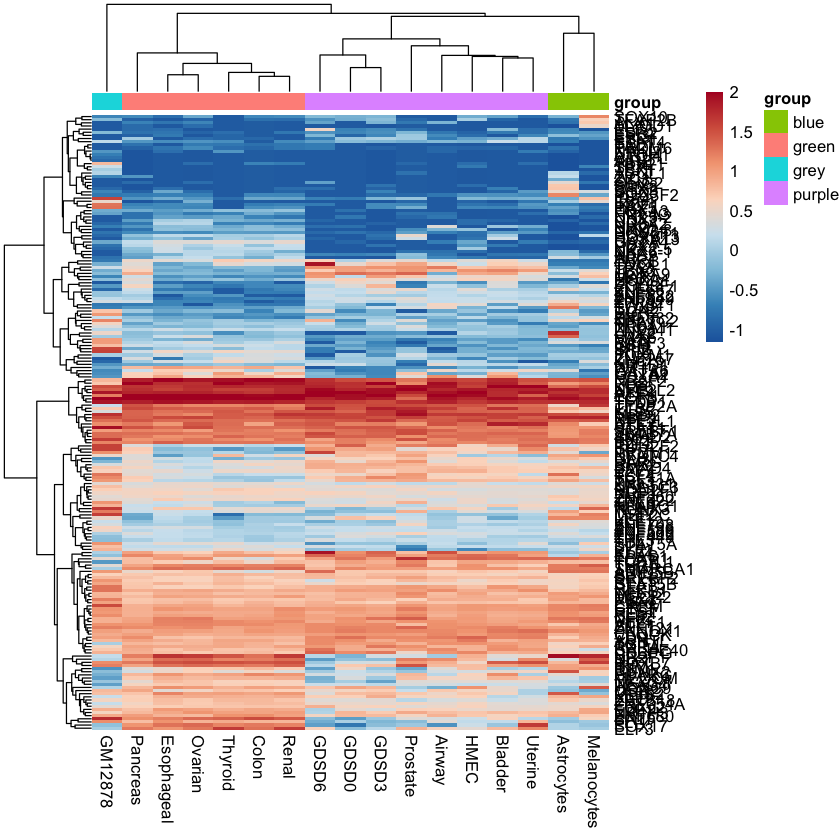

In [27]:
p_with_genes = pheatmap(rna_df_tissue_norm_sig,
             cluster_rows=T,
             cluster_cols=T,
            scale_col=T,
#             fontsize=4,
             annotation_col=annon_df,
               color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

save_pheatmap_pdf(p_with_genes, paste0(save_prefix, 'rna_tf_heatmap_by_group.pdf'), width=10, height=40) 

In [28]:
tf_ordering = rownames(rna_df_tissue_norm_sig)[p_with_genes$tree_row[["order"]]]


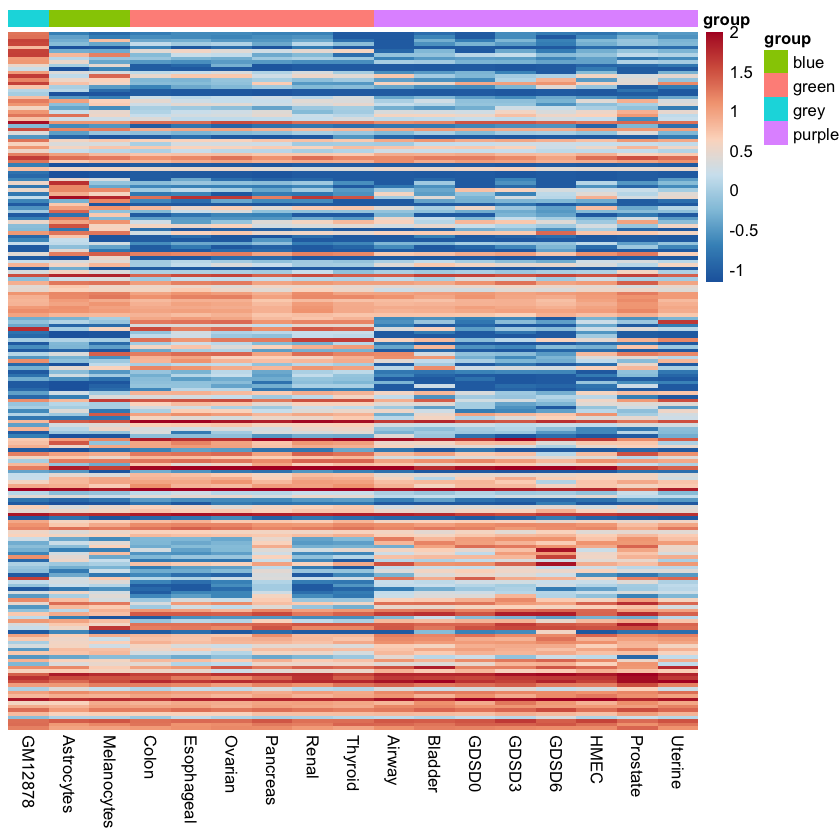

In [29]:
p_no_genes = pheatmap(rna_df_tissue_norm_sig,
             cluster_rows=F,
             cluster_cols=F,
                show_rownames=F,
             annotation_col=annon_df,
               color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

# save_pheatmap_png(p_no_genes, paste0(save_prefix, 'rna_heatmap_no_genes.png'), width=3000, height=3000, res = 500) 

# save tf signatures

In [30]:
select_genes[select_genes %in% TF_unique_tissue]

[1] "IKZF1"  "PAX5"   "SPIB"   "IRF8"   "MYB"    "HIC1"   "BATF3"  "STAT5A"
 [9] "LHX2"   "POU3F2" "TWIST1" "SOX10"  "PAX6"   "SOX2"   "RUNX2"  "OTX2"  
[17] "NFATC1" "OSR2"   "FOXJ2"  "POU3F1" "GLI3"

In [31]:
purple_TFs= sig_genes_list$purple[ sig_genes_list$purple %in% select_genes]
length(purple_TFs)
green_TFs = sig_genes_list$green[ sig_genes_list$green %in% select_genes]
length(green_TFs)
blue_TFs  = sig_genes_list$blue[ sig_genes_list$blue %in% select_genes]
length(blue_TFs)
grey_TFs  = sig_genes_list$grey[ sig_genes_list$grey %in% select_genes]
length(grey_TFs)
all_genes = rownames(rna_df_tissue_norm)
length(all_genes)

[1] 56

[1] 66

[1] 44

[1] 41

[1] 24811

In [32]:
tf_group_df = rbind(data.frame(tf=purple_TFs,group='purple'),
      data.frame(tf=green_TFs,group='green'),
      data.frame(tf=grey_TFs,group='grey'),
      data.frame(tf=blue_TFs,group='blue'))

tf_group_df = tf_group_df %>%
    group_by(tf)%>%
    mutate(group_str = paste0(group, collapse = "|")) %>%
    ungroup()%>%
    dplyr::select(-group)%>%
    distinct()%>%
    column_to_rownames("tf")


In [33]:
tissue = 'GDSD0'
group = annon_df[tissue,]


In [34]:
# write.table(sort(purple_TFs), file = paste0(save_prefix, "purple_TFs.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(green_TFs), file = paste0(save_prefix, "green_TFs.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(blue_TFs), file = paste0(save_prefix, "blue_TFs.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(grey_TFs), file = paste0(save_prefix, "grey_TFs.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(select_genes), file = paste0(save_prefix, "select_TFs.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(all_genes), file = paste0(save_prefix, "all_genes.csv"),row.names=FALSE,col.names=FALSE)


# get gene targets of the tfs (looped regions and promoter regions) and find reactome enrichment

In [35]:
all_entrez = bitr(all_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID


'select()' returned 1:many mapping between keys and columns



In [36]:
# ##RUN ONCE ###
# overall_df = data.frame()
# # for (tissue in normal_tissues){
# #     print(tissue)
# #     tissue_crm_file = paste0('../data/processed/tissue_crms/combined_tissue/',tissue,'_crm.csv')
# #     tissue_crm_df = read.csv(tissue_crm_file,row.names=1)
# #     group = annon_df[tissue,]
# #     tfs_in_group = sort(rownames(tf_group_df)[tf_group_df==group])

# #     for (tf in tfs_in_group){
#         if (tf %in% colnames(tissue_crm_df)){
#             print(tf)
#             target_genes = rownames(tissue_crm_df)[tissue_crm_df[,tf]>0]
#             target_genes_entrez = bitr(target_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
#             print(length(target_genes_entrez))
#             er = enrichPathway(
#                                 gene = target_genes_entrez, organism = "human", pvalueCutoff = 0.05, pAdjustMethod = "none", qvalueCutoff = 0.5, 
#                                 universe = all_entrez,
#                                 readable      = TRUE
#                             )
            
            
#             er_df = data.frame(er)
#             if (dim(er_df)[1] >0){
#                 er_df$tf = tf
#                 er_df$tissue = tissue
#                 er_df$num_target_genes = length(target_genes_entrez)
#                 rownames(er_df) = NULL
#                 overall_df = rbind(overall_df, er_df)
#             }
#         }
#     }
# }

In [37]:
# write.csv(overall_df,paste0(save_prefix, 'tf_tissue_tg.csv'))

In [38]:
# ##RUN ONCE ###
# overall_df_go = data.frame()
# for (tissue in normal_tissues){
#     print(tissue)
#     tissue_crm_file = paste0('../data/processed/tissue_crms/combined_tissue/',tissue,'_crm.csv')
#     tissue_crm_df = read.csv(tissue_crm_file,row.names=1)
#     group = annon_df[tissue,]
#     tfs_in_group = sort(rownames(tf_group_df)[tf_group_df==group])

#     for (tf in tfs_in_group){
#         if (tf %in% colnames(tissue_crm_df)){
#             print(tf)
#             target_genes = rownames(tissue_crm_df)[tissue_crm_df[,tf]>0]
#             target_genes_entrez = bitr(target_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
#             print(length(target_genes_entrez))
#             ego <- enrichGO(gene          = target_genes_entrez,
#                 universe      = all_entrez,
#                 OrgDb         = org.Hs.eg.db,
#                 ont           = "BP",
#                 pAdjustMethod = "BH",
#                 pvalueCutoff  = 0.3,
#                 qvalueCutoff  = 0.2)
#             er_df = data.frame(ego)
#             print(dim(er_df)[1])
#             if (dim(er_df)[1] >0){
#                 er_df$tf = tf
#                 er_df$tissue = tissue
#                 er_df$num_target_genes = length(target_genes_entrez)
#                 rownames(er_df) = NULL
#                 overall_df_go = rbind(overall_df_go, er_df)
#             }
#         }
#     }
# }

In [39]:
# write.csv(overall_df_go,paste0(save_prefix, 'tf_tissue_tg_go_2.csv'))

# go BP

In [40]:
tissue_colors = read.csv(paste0(save_prefix, 'tissue_colors.csv'))

In [41]:
overall_df_go = read.csv(paste0(save_prefix, 'tf_tissue_tg_go_2.csv'),row.names=1,stringsAsFactors=F)#,stringAsFactors=F)
overall_df_go$tissue = as.character(overall_df_go$tissue)

In [42]:
tf_df = overall_df_go%>% group_by(tf)%>%summarize(n())%>%arrange(tf)

In [43]:
overall_df_go%>% group_by(tissue)%>%summarize(n())

tissue      n() 
1  Airway      1579
2  Astrocytes  5447
3  Bladder      851
4  Colon       1930
5  Esophageal  1074
6  GDSD0        201
7  GDSD3       1994
8  GDSD6        668
9  GM12878      761
10 HMEC        1869
11 Melanocytes 2534
12 Ovarian     4176
13 Pancreas     591
14 Prostate    5679
15 Renal        378
16 Thyroid      193
17 Uterine       96

In [44]:
colnames(overall_df_go)

[1] "ID"               "Description"      "GeneRatio"        "BgRatio"         
 [5] "pvalue"           "p.adjust"         "qvalue"           "geneID"          
 [9] "Count"            "tf"               "tissue"           "num_target_genes"

In [45]:
descriptions = overall_df_go%>% dplyr::select(Description) %>% unique()%>% arrange(Description)
write.csv(descriptions, paste0(save_prefix,'go_descriptions_2.csv'))#group_by(tf)%>%summarize(n())

In [46]:
overall_df_go%>%
    filter(p.adjust < 0.05)%>%
    dplyr::select(tf)%>%
    distinct()%>%
    dim()

[1] 89  1

In [47]:
# num of descriptions that are significant
length(unique(overall_df_go[overall_df_go[["p.adjust"]] < 0.05,]$Description))

[1] 535

### manually choose some go descriptions to include

In [48]:
indices_picked = read.csv('../data//processed/fig3_footprinting/tf_go_indices.csv')$Indices
descriptions_picked = sort(unique(overall_df_go[indices_picked,'Description']))
length(descriptions_picked)
tfs_picked = sort(unique(overall_df_go[indices_picked,'tf']))
length(tfs_picked)

[1] 92

[1] 95

In [49]:
# overall_df_go_filt = filter(overall_df_go, Description %in% descriptions_picked)
# overall_df_go_filt = filter(overall_df_go_filt, tf %in% tfs_picked)
overall_df_go_filt = overall_df_go[indices_picked,]

In [50]:
dim(overall_df_go_filt)

[1] 445  12

In [51]:
groups_df = rna_genes_result_normal%>% dplyr::select(tissues,group)%>%unique()
groups_df$tissues = as.character(groups_df$tissues)
rownames(groups_df) = NULL
groups_df[groups_df$group=='purple',]

tissues  group 
1  Airway   purple
3  Bladder  purple
6  GDSD0    purple
7  GDSD3    purple
8  GDSD6    purple
10 HMEC     purple
14 Prostate purple
17 Uterine  purple

In [52]:
select_group = function(df,group_str){
    df_group = df%>%
        left_join(groups_df, by=c('tissue'='tissues'))%>%
        filter(group==group_str)%>%
        mutate(pvalue = pmin(1,pvalue*dim(groups_df[groups_df$group==group_str,])[1]))%>%
#         filter(pvalue<.05)%>%
        dplyr::select('Description','tissue','pvalue','tf')%>%
        group_by(tf,Description)%>%
        summarise(pval = min(pvalue), n= n())%>%
        mutate(pval_correct = pmin(1, pval*n))%>%
#         filter(pval_correct<0.05)%>%
        mutate(group = group_str)
}

In [53]:
overall_df_go_purple = select_group(overall_df_go_filt, 'purple')
dim(overall_df_go_purple)
overall_df_go_grey = select_group(overall_df_go_filt, 'grey')
dim(overall_df_go_grey)
overall_df_go_green = select_group(overall_df_go_filt, 'green')
dim(overall_df_go_green)
overall_df_go_blue = select_group(overall_df_go_filt, 'blue')
dim(overall_df_go_blue)

[1] 195   6

[1] 17  6

[1] 108   6

[1] 49  6

In [54]:
overall_df_regrouped_go = rbind(overall_df_go_purple, overall_df_go_grey, overall_df_go_green, overall_df_go_blue)
overall_df_regrouped_go = overall_df_regrouped_go%>%
    group_by(tf, Description)%>%
    summarise(pval = min(pval_correct), n= n())%>%
    mutate(pval_correct = pmin(1, pval*n))%>%
    filter(pval_correct<0.05)%>%
    arrange(pval_correct)%>%
    mutate(log10_pval = -log10(pval_correct))
overall_df_regrouped_go$Description = as.character(overall_df_regrouped_go$Description)

In [55]:
length(unique(overall_df_regrouped_go$tf))

[1] 73

In [56]:
# stat_descr_count = overall_df_regrouped_go%>%
#     group_by(Description)%>%
#     summarize(count=n())%>%
#     mutate(name = if_else(count>1, Description, ''))%>%
#     column_to_rownames( 'Description')%>%
#     dplyr::select(-count)

In [57]:
# descr_plus_2 = overall_df_regrouped_go%>%
#     group_by(Description)%>%
#     summarize(count=n())%>%
#     filter(count>1)
# descr_plus_2= descr_plus_2$Description

In [58]:
# overall_df_regrouped_go

In [59]:
# overall_df_regrouped_go_spread = overall_df_regrouped_go%>%
#     dplyr::select('Description','pval_correct','tf')%>%
#     spread('Description', 'pval_correct', fill = 1, convert = FALSE)
# rownames(overall_df_regrouped_spread) = overall_df_regrouped_spread$tf
# overall_df_regrouped_go_spread = column_to_rownames(overall_df_regrouped_go_spread,"tf")

# # get ordering of tfs that matches above heatmap
# select_tfs_post_enrich_go = tf_ordering[tf_ordering %in% rownames(overall_df_regrouped_go_spread)]
# length(select_tfs_post_enrich_go)
# overall_df_regrouped_go_spread = overall_df_regrouped_go_spread[select_tfs_post_enrich_go,]
# dim(overall_df_regrouped_go_spread)

# if (length(nearZeroVar(overall_df_regrouped_go_spread)) > 0) {
#   overall_df_regrouped_go_spread_highVar <- overall_df_regrouped_go_spread[, -nearZeroVar(overall_df_regrouped_go_spread)]
# }
# rownames(overall_df_regrouped_go_spread_highVar) = select_tfs_post_enrich_go
# dim(overall_df_regrouped_go_spread_highVar)

In [60]:
# colnames(overall_df_regrouped_go_spread_highVar)

### re order and filter the rna expression

In [61]:
# overall_df_regrouped_go_spread_select_col = overall_df_regrouped_go_spread[,]
# dim(overall_df_regrouped_go_spread_select_col)

In [62]:
# select_tfs_post_go_term = rownames(overall_df_regrouped_go_spread)
select_tfs_post_go_term =unique(overall_df_regrouped_go$tf)# tf_df$tf
length(select_tfs_post_go_term)

[1] 73

In [63]:
rna_df_tissue_tf_normal = rna_df_tissue[select_tfs_post_go_term,normal_tissue_order]
rna_df_tissue_tf_normal_log = log2(rna_df_tissue_tf_normal+1e-2)
rna_df_tissue_tf_normal_log_norm = as.data.frame(scale(rna_df_tissue_tf_normal_log, center = TRUE, scale = TRUE))
rna_df_tissue_tf_normal_log_norm[rna_df_tissue_tf_normal_log_norm< (-2)] = -2
rna_df_tissue_tf_normal_log_norm[rna_df_tissue_tf_normal_log_norm> (2)] = 2
# rna_df_tissue_tf_normal_log_norm = rna_df_tissue_tf_normal_log_norm[apply(rna_df_tissue_tf_normal_log_norm,1,max)>0 ,]
# rna_df_tissue_tf_normal_log_norm = rna_df_tissue_tf_normal_log_norm[apply(rna_df_tissue_tf_normal_log_norm,1,sum)< 14,]
# rna_df_tissue_tf_normal_log_norm = rna_df_tissue_tf_normal_log_norm[apply(rna_df_tissue_tf_normal_log_norm,1,sd)>0.2 ,]

pdf 
  2

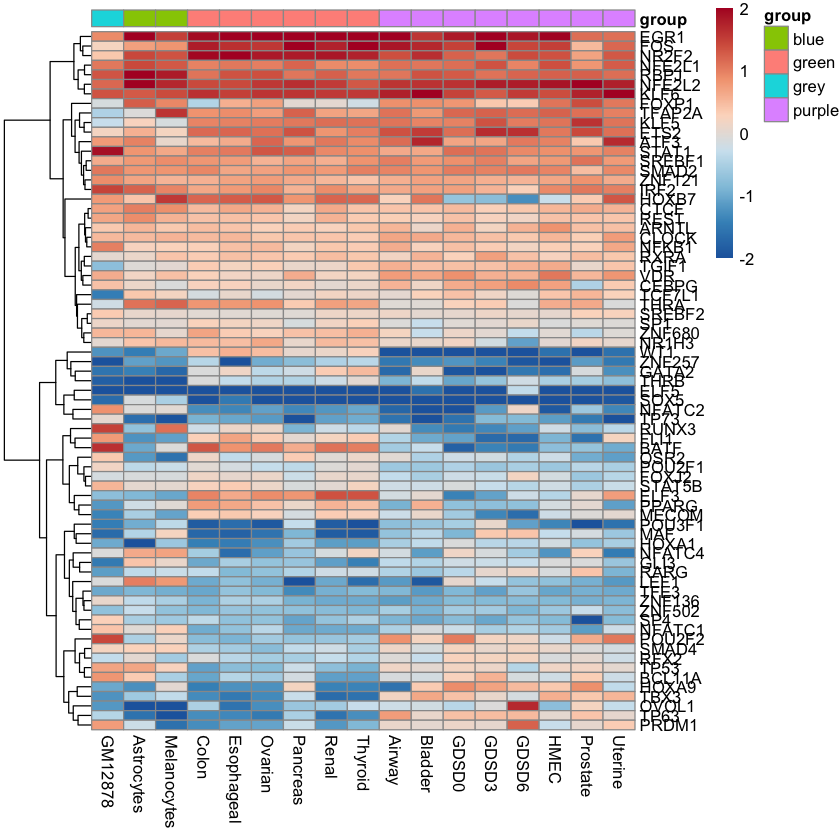

In [64]:
p_with_genes = pheatmap(rna_df_tissue_tf_normal_log_norm,
             cluster_rows=T,
             cluster_cols=F,
            scale_row=T,
            scale_col=T,
#             fontsize=4,
             annotation_col=annon_df,
               color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

save_pheatmap_pdf(p_with_genes, paste0(save_prefix, 'rna_tf_heatmap_by_group_post_goterm.pdf'), width=10, height=20) 

In [65]:
tf_ordering = rownames(rna_df_tissue_tf_normal_log_norm)[p_with_genes$tree_row[["order"]]]
length(tf_ordering)

[1] 73

In [66]:
overall_df_regrouped_go_spread = overall_df_regrouped_go%>%
    dplyr::select('Description','pval_correct','tf')%>%
    spread('Description', 'pval_correct', fill = 1, convert = FALSE)
overall_df_regrouped_go_spread = column_to_rownames(overall_df_regrouped_go_spread,"tf")
overall_df_regrouped_go_spread = overall_df_regrouped_go_spread[tf_ordering,]
# overall_df_regrouped_go_spread_highVar = overall_df_regrouped_go_spread_highVar[tf_ordering,]

In [74]:
overall_df_regrouped_go = rbind(overall_df_go_purple, overall_df_go_grey, overall_df_go_green, overall_df_go_blue)
overall_df_regrouped_go = overall_df_regrouped_go%>%
#     group_by(tf, Description)%>%
#     summarise(pval = min(pval_correct), n= n())%>%
#     mutate(pval_correct = pmin(1, pval*n))%>%
#     filter(pval_correct<0.05)%>%
#     arrange(pval_correct)%>%
    mutate(log10_pval = -log10(pval_correct))
overall_df_regrouped_go$Description = as.character(overall_df_regrouped_go$Description)

overall_df_regrouped_go_reduced = overall_df_regrouped_go %>% 
    group_by(tf, Description) %>% 
    filter(log10_pval == min(log10_pval)) %>%
    filter(1:n() == 1)

In [75]:
overall_df_regrouped_go_spread = overall_df_regrouped_go_reduced%>%
    dplyr::select('Description','log10_pval','tf')%>%
    spread('Description', 'log10_pval', fill = 0, convert = FALSE)
# rownames(overall_df_regrouped_spread) = overall_df_regrouped_spread$tf
overall_df_regrouped_go_spread = column_to_rownames(overall_df_regrouped_go_spread,"tf")


pdf 
  2

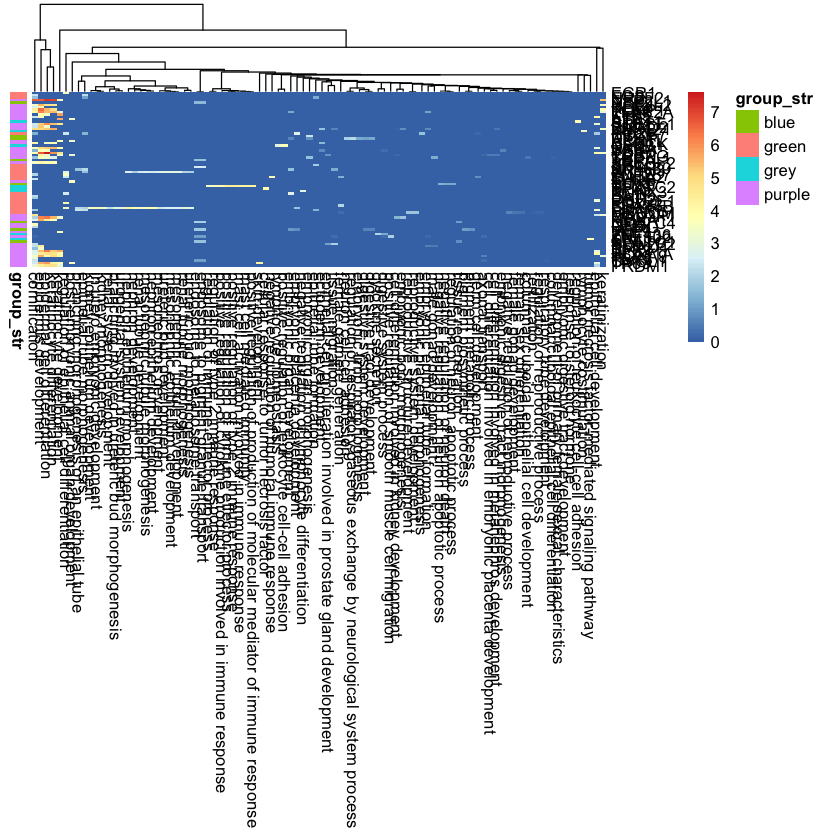

In [76]:
p_go = pheatmap(overall_df_regrouped_go_spread[tf_ordering,],
        cluster_rows=F,
                      annotation_row=tf_group_df)

save_pheatmap_pdf(p_go, paste0(save_prefix, 'overall_df_regrouped_go_spread.pdf'), width=20, height=20) 

In [77]:
# go_term_ordering = colnames(overall_df_regrouped_go_spread)[p_go$tree_col[["order"]]]
# go_term_ordering
# go_term_ordering_sel = go_term_ordering[c(1:3,5:9,13,20,27:29,38:51,56:91)]
# # go_term_ordering_sel = go_term_ordering[c(1:3,5:9,13,18,27:28,30,39:63)]

In [78]:
# write.csv(go_term_ordering_sel,paste0(save_prefix,'go_term_ordering_sel.csv'))
go_term_ordering_sel= as.character(read.csv(paste0(save_prefix,'go_term_ordering_sel.csv'))$x)
go_term_ordering_sel

[1] "cornification"                                                       
 [2] "epidermis development"                                               
 [3] "epidermal cell differentiation"                                      
 [4] "keratinocyte development"                                            
 [5] "regulation of epithelial cell differentiation"                       
 [6] "post-embryonic animal organ development"                             
 [7] "branching morphogenesis of an epithelial tube"                       
 [8] "epithelial tube morphogenesis"                                       
 [9] "renal system development"                                            
[10] "nephron epithelium development"                                      
[11] "endosome to melanosome transport"                                    
[12] "endosome to pigment granule transport"                               
[13] "regulation of immune effector process"                               
[14] "cellular response to tumor necrosis factor"                          
[15] "negative regulation of humoral immune response"                      
[16] "lymphocyte homeostasis"                                              
[17] "positive regulation of leukocyte cell-cell adhesion"                 
[18] "embryonic organ development"                                         
[19] "embryonic placenta development"                                      
[20] "negative regulation of lymphocyte differentiation"                   
[21] "embryonic organ morphogenesis"                                       
[22] "epithelial tube formation"                                           
[23] "ectoderm development"                                                
[24] "epithelial cell proliferation involved in prostate gland development"
[25] "tissue migration"                                                    
[26] "female gamete generation"                                            
[27] "neuron cell-cell adhesion"                                           
[28] "cytokine secretion"                                                  
[29] "digestive system process"                                            
[30] "positive regulation of smooth muscle cell migration"                 
[31] "cell differentiation involved in kidney development"                 
[32] "embryonic body morphogenesis"                                        
[33] "reproductive structure development"                                  
[34] "reproductive system development"                                     
[35] "embryonic placenta morphogenesis"                                    
[36] "embryonic epithelial tube formation"                                 
[37] "male gonad development"                                              
[38] "negative regulation of neuron apoptotic process"                     
[39] "negative regulation of neuron death"                                 
[40] "regulation of neuron apoptotic process"                              
[41] "tissue regeneration"                                                 
[42] "pigment biosynthetic process"                                        
[43] "pigment metabolic process"                                           
[44] "germ cell development"                                               
[45] "axonal transport"                                                    
[46] "cell differentiation involved in embryonic placenta development"     
[47] "cell differentiation involved in metanephros development"            
[48] "embryonic digestive tract morphogenesis"                             
[49] "negative regulation of reproductive process"                         
[50] "female gonad development"                                            
[51] "female sex differentiation"                                          
[52] "columnar/cuboidal epithelial cell development"                       
[53] "fertilization"                             

pdf 
  2

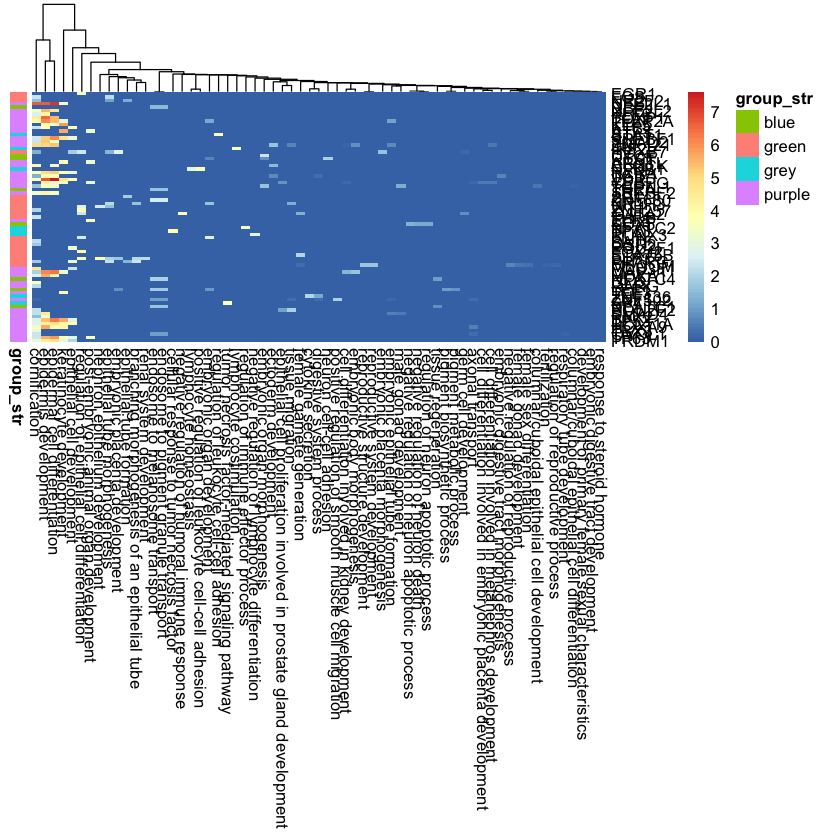

In [79]:
p_go_sel = pheatmap(overall_df_regrouped_go_spread[tf_ordering,go_term_ordering_sel],
        cluster_rows=F,
                      annotation_row=tf_group_df)

save_pheatmap_pdf(p_go_sel, paste0(save_prefix, 'overall_df_regrouped_go_spread_sel.pdf'), width=10, height=20) 

In [80]:
dim(overall_df_regrouped_go_spread[tf_ordering,go_term_ordering_sel])

[1] 73 63

### color by tissue

In [81]:
overall_df_go_filt_with_groups = overall_df_go_filt%>%
    left_join(groups_df, by=c('tissue'='tissues'))%>%
    left_join(tissue_colors, by='tissue')%>%
    mutate(log10_pval=-log10(p.adjust))%>%
    filter(Description %in% go_term_ordering_sel)%>%
    filter(tf %in% tf_ordering)
dim(overall_df_go_filt_with_groups)
# overall_df_go_filt_with_groups    


Warning message:
“Column `tissue` joining character vector and factor, coercing into character vector”


[1] 313  15

In [82]:
tissue_order = as.character(tissue_colors$tissue)
color_order = as.character(tissue_colors$color)

In [270]:
write.csv(overall_df_go_filt_with_groups, paste0(save_prefix,'overall_df_go_filt_with_groups.csv'))

In [85]:
overall_df_go_filt_with_groups = read.csv(paste0(save_prefix,'overall_df_go_filt_with_groups.csv'),stringsAsFactor=F)
dim(overall_df_go_filt_with_groups)

[1] 313  16

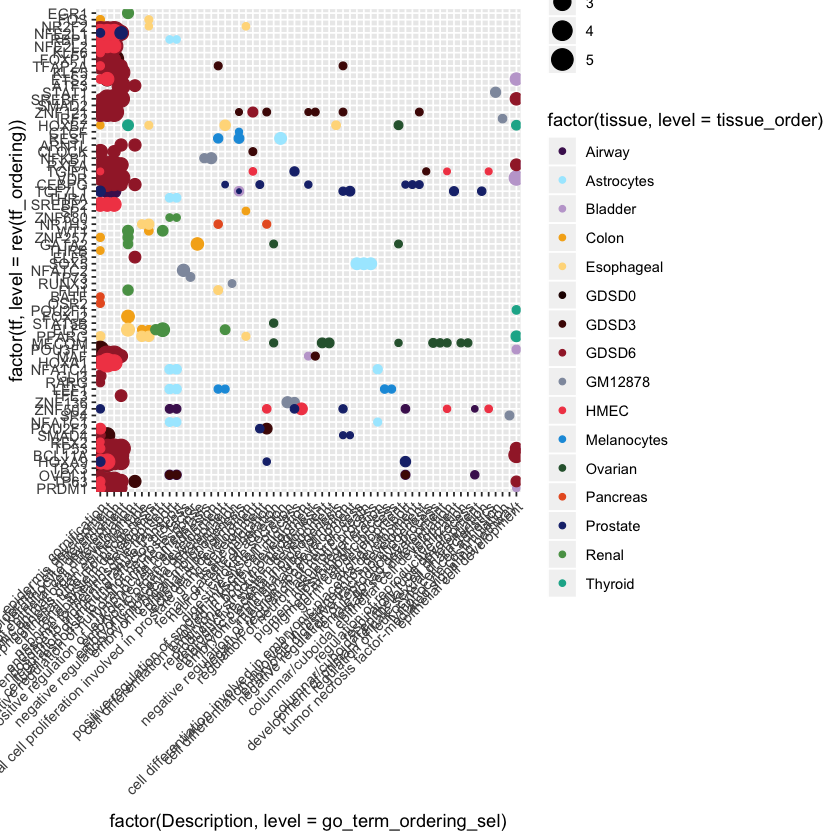

In [93]:
p_dot_tissue = ggplot(overall_df_go_filt_with_groups, aes(x=factor(Description,level=go_term_ordering_sel), y = factor(tf,level=rev(tf_ordering)),
                                                   color=factor(tissue, level=tissue_order)))+
    geom_point(aes(size=log10_pval))+
    scale_color_manual(values=color_order)+
    theme(axis.text.x = element_text(angle = 45,hjust=1))
p_dot_tissue
ggsave(file = paste0(save_prefix, "overall_df_regrouped_go_reduced_bytissue.eps"),height=20, width=15)
# # level_order <- c('virginica', 'versicolor', 'setosa') #this vector might be useful for other plots/analyses
# ggplot(overall_df_regrouped_go, aes(x = factor(Description, y = tf)) + 
#      geom_point(aes( size=log10_pval)) +#,colour="black",pch=21)
#   theme(axis.text.x = element_text(angle = 45))
# #   scale_size_area(max_size = 10)

### color by group

In [244]:
# check to make sure all tfs are preserved
overall_df_regrouped_go_reduced = overall_df_regrouped_go_reduced%>%
    filter(Description %in% go_term_ordering_sel)%>%
    filter(tf %in% tf_ordering)
overall_df_regrouped_go_reduced%>%
    group_by(tf)%>%
    summarise(n())%>%dim()

[1] 73  2

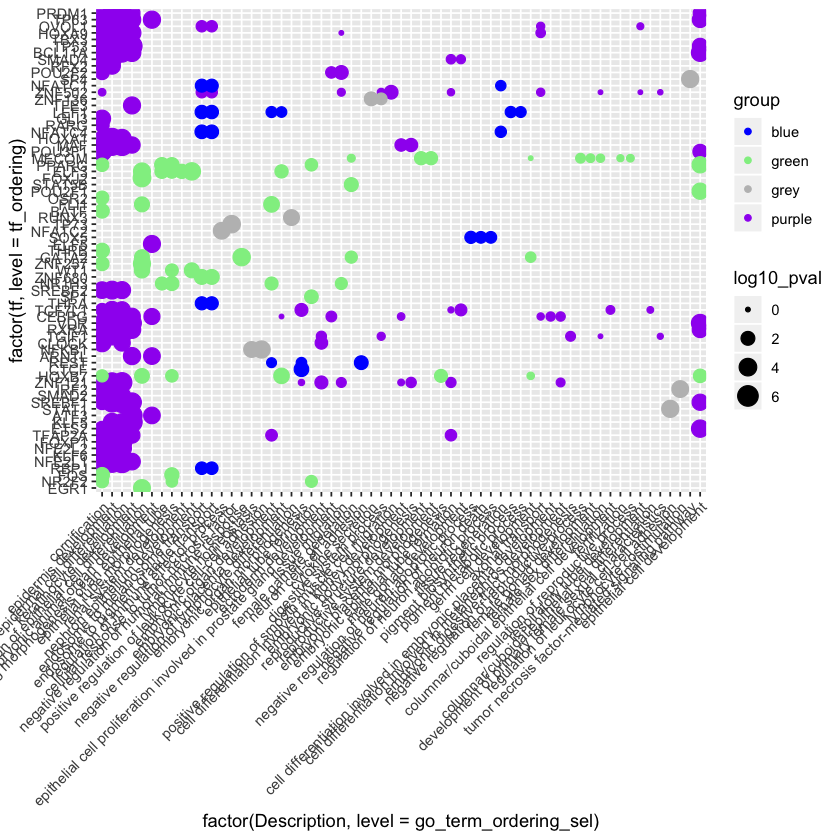

In [246]:
p_dot = ggplot(overall_df_regrouped_go_reduced, aes(x=factor(Description,level=go_term_ordering_sel), y = factor(tf,level=tf_ordering),
                                                   color=group))+
    geom_point(aes(size=log10_pval))+
    scale_color_manual(values=c("blue", "lightgreen", "grey","purple"))+
    theme(axis.text.x = element_text(angle = 45,hjust=1))
p_dot
ggsave(file = paste0(save_prefix, "overall_df_regrouped_go_reduced.eps"),height=20, width=15)
# # level_order <- c('virginica', 'versicolor', 'setosa') #this vector might be useful for other plots/analyses
# ggplot(overall_df_regrouped_go, aes(x = factor(Description, y = tf)) + 
#      geom_point(aes( size=log10_pval)) +#,colour="black",pch=21)
#   theme(axis.text.x = element_text(angle = 45))
# #   scale_size_area(max_size = 10)

In [192]:
dim(-log10(overall_df_regrouped_go_spread[,descr_plus_2]))
p_go_highvar = pheatmap(-log10(overall_df_regrouped_go_spread_highVar),
        cluster_rows=T,
                      annotation_row=tf_group_df)

save_pheatmap_pdf(p_go_highvar, paste0(save_prefix, 'overall_df_regrouped_go_spread_highVar.pdf'), width=15, height=15) 

[1]  47 127

pdf 
  2

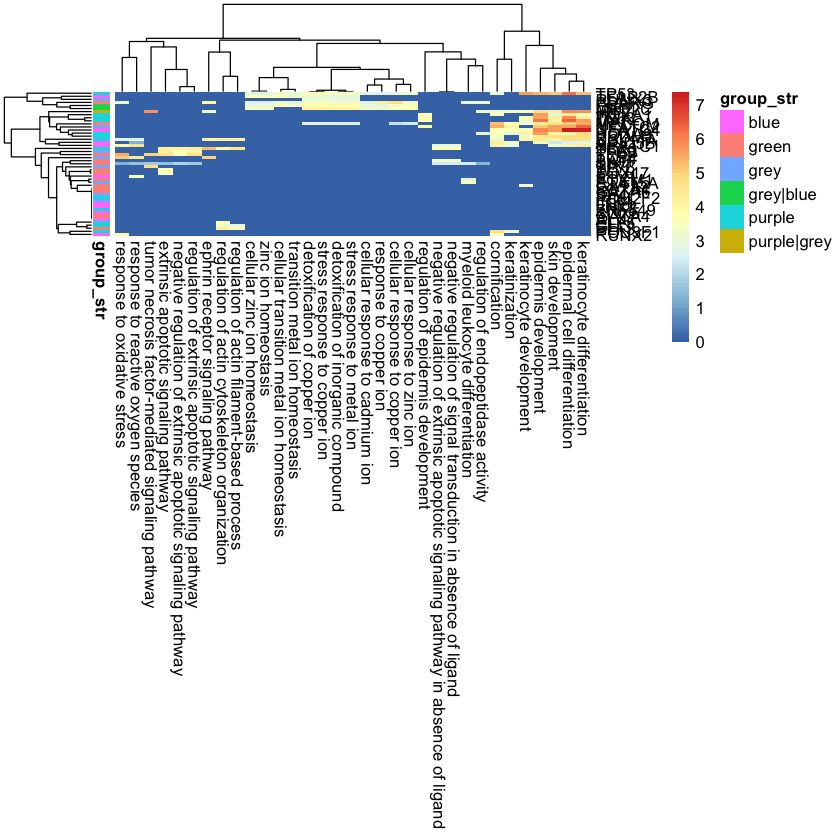

In [170]:
p_go_highvar = pheatmap(-log10(overall_df_regrouped_go_spread_highVar),
        cluster_rows=T,
                      annotation_row=tf_group_df)

save_pheatmap_pdf(p_go_highvar, paste0(save_prefix, 'overall_df_regrouped_go_spread_highVar.pdf'), width=15, height=15) 

In [ ]:
p_with_genes_after_go = pheatmap(rna_df_tissue_norm_sig[[,
             cluster_rows=T,
             cluster_cols=T,
            scale_col=T,
#             fontsize=4,
             annotation_col=annon_df,
               color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

save_pheatmap_png(p_with_genes, paste0(save_prefix, 'rna_tf_heatmap_by_group.png'), width=1200, height=4000, res = 200) 

# Reactome

In [34]:
overall_df = read.csv(paste0(save_prefix, 'tf_tissue_tg.csv'),row.names=1)

In [35]:
head(overall_df)
dim(overall_df)

ID            Description                                          GeneRatio
1 R-HSA-6809371 Formation of the cornified envelope                  3/19     
2 R-HSA-6805567 Keratinization                                       3/19     
3 R-HSA-174437  Removal of the Flap Intermediate from the C-strand   1/19     
4 R-HSA-174414  Processive synthesis on the C-strand of the telomere 1/19     
5 R-HSA-71288   Creatine metabolism                                  1/19     
6 R-HSA-2029481 FCGR activation                                      1/19     
  BgRatio   pvalue      p.adjust    qvalue    geneID             Count tf    
1 128/10497 0.001487749 0.001487749 0.1894923 KRT13/KRT33A/KRT6B 3     ARID5B
2 213/10497 0.006279569 0.006279569 0.2023190 KRT13/KRT33A/KRT6B 3     ARID5B
3 10/10497  0.017961326 0.017961326 0.2023190 POLD4              1     ARID5B
4 11/10497  0.019740552 0.019740552 0.2023190 POLD4              1     ARID5B
5 11/10497  0.019740552 0.019740552 0.2023190 SLC6A11            1     ARID5B
6 12/10497  0.021516723 0.021516723 0.2023190 FCGR3A             1     ARID5B
  tissue num_target_genes
1 Airway 21              
2 Airway 21              
3 Airway 21              
4 Airway 21              
5 Airway 21              
6 Airway 21

[1] 12254    12

In [38]:
overall_df$tissue = as.character(overall_df$tissue)

In [61]:
overall_df_purple = select_group(overall_df, 'purple')
dim(overall_df_purple)
overall_df_grey = select_group(overall_df, 'grey')
dim(overall_df_grey)
overall_df_green = select_group(overall_df, 'green')
dim(overall_df_green)
overall_df_blue = select_group(overall_df, 'blue')
dim(overall_df_blue)

[1] 810   5

[1] 1106    5

[1] 725   5

[1] 883   5

In [64]:
overall_df_regrouped = rbind(overall_df_purple, overall_df_grey, overall_df_green, overall_df_blue)
overall_df_regrouped = overall_df_regrouped%>%
    group_by(tf, Description)%>%
    summarise(pval = min(pval_correct), n= n())%>%
    mutate(pval_correct = pmin(1, pval*n))%>%
    filter(pval_correct<0.05)%>%
    arrange(pval_correct)


In [65]:
# overall_df_purple[overall_df_purple$tf %in% purple_TFs,]%>%arrange(pval_correct)%>%head(10)
# overall_df_purple%>%arrange(pval_correct)%>%head(10)

In [131]:
overall_df_regrouped_spread = overall_df_regrouped%>%
    dplyr::select('Description','pval_correct','tf')%>%
    spread('Description', 'pval_correct', fill = 1, convert = FALSE)
# rownames(overall_df_regrouped_spread) = overall_df_regrouped_spread$tf
overall_df_regrouped_spread = column_to_rownames(overall_df_regrouped_spread,"tf")

# get ordering of tfs that matches above heatmap
select_tfs_post_enrich = tf_ordering[tf_ordering %in% rownames(overall_df_regrouped_spread)]
length(select_tfs_post_enrich)

overall_df_regrouped_spread = overall_df_regrouped_spread[select_tfs_post_enrich,]
dim(overall_df_regrouped_spread)

if (length(nearZeroVar(overall_df_regrouped_spread)) > 0) {
  overall_df_regrouped_spread_highVar <- overall_df_regrouped_spread[, -nearZeroVar(overall_df_regrouped_spread)]
}
rownames(overall_df_regrouped_spread_highVar) = select_tfs_post_enrich
dim(overall_df_regrouped_spread_highVar)

[1] 74

[1]  74 736

[1]  74 166

pdf 
  2

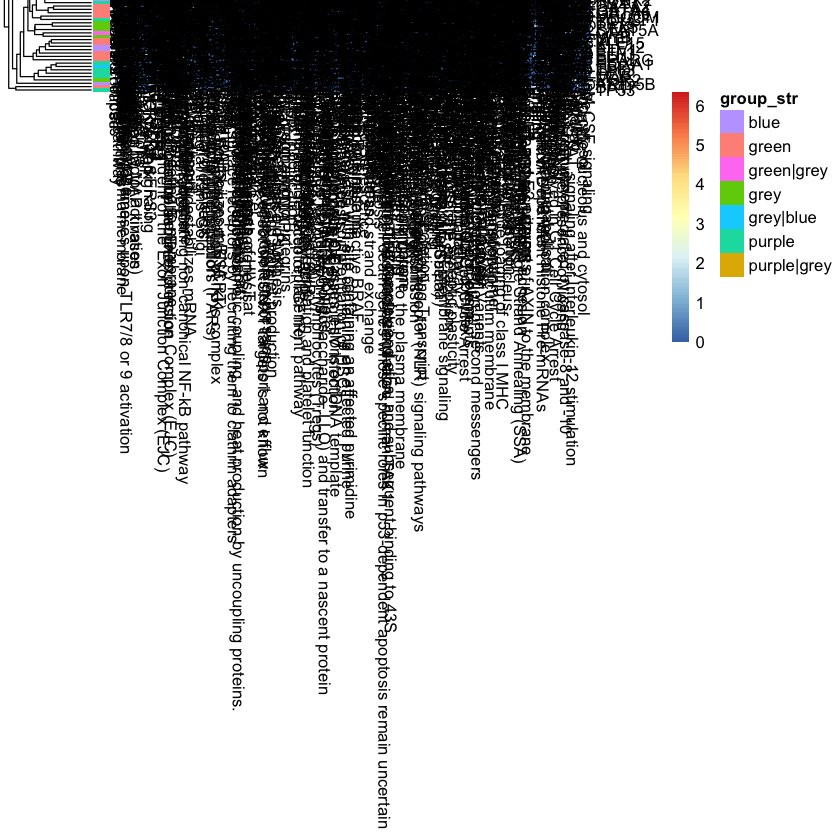

In [136]:
p_reactome = pheatmap(-log10(overall_df_regrouped_spread),
        cluster_rows=T,
                      annotation_row=tf_group_df)

save_pheatmap_pdf(p_reactome, paste0(save_prefix, 'overall_df_regrouped_spread.pdf'), width=100, height=20) 

In [81]:

colnames(overall_df_regrouped_spread)

[1] "tf"                                                                                                                                  
  [2] "Abacavir transport and metabolism"                                                                                                   
  [3] "Acetylcholine Neurotransmitter Release Cycle"                                                                                        
  [4] "Activated NOTCH1 Transmits Signal to the Nucleus"                                                                                    
  [5] "Activated NTRK2 signals through FRS2 and FRS3"                                                                                       
  [6] "activated TAK1 mediates p38 MAPK activation"                                                                                         
  [7] "Activation of ATR in response to replication stress"                                                                                 
  [8] "Activation of BAD and translocation to mitochondria "                                                                                
  [9] "Activation of BH3-only proteins"                                                                                                     
 [10] "Activation of kainate receptors upon glutamate binding"                                                                              
 [11] "Activation of PPARGC1A (PGC-1alpha) by phosphorylation"                                                                              
 [12] "Activation of SMO"                                                                                                                   
 [13] "Activation of the mRNA upon binding of the cap-binding complex and eIFs, and subsequent binding to 43S"                              
 [14] "Acyl chain remodelling of PC"                                                                                                        
 [15] "Acyl chain remodelling of PS"                                                                                                        
 [16] "ADP signalling through P2Y purinoceptor 1"                                                                                           
 [17] "ADP signalling through P2Y purinoceptor 12"                                                                                          
 [18] "Advanced glycosylation endproduct receptor signaling"                                                                                
 [19] "AKT phosphorylates targets in the cytosol"                                                                                           
 [20] "alpha-linolenic (omega3) and linoleic (omega6) acid metabolism"                                                                      
 [21] "alpha-linolenic acid (ALA) metabolism"                                                                                               
 [22] "Alpha-protein kinase 1 signaling pathway"                                                                                            
 [23] "Amine ligand-binding receptors"                                                                                                      
 [24] "Amino acid transport across the plasma membrane"                                                                                     
 [25] "Amyloid fiber formation"                                                                                                             
 [26] "Anchoring fibril formation"                                                                                                          
 [27] "Antigen activates B Cell Receptor (BCR) leading to generation of second messengers"                                                  
 [28] "Antigen Presentation: Folding, assembly and peptide loading of class I MHC"                                                          
 [29] "Apoptosis"                                     

pdf 
  2

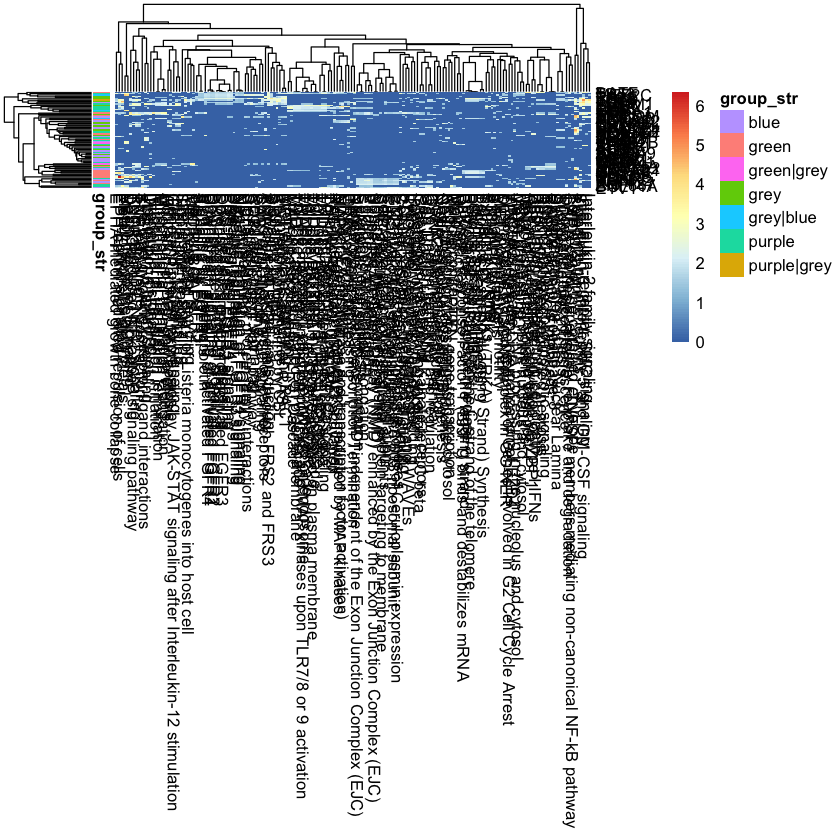

In [137]:
p_reactome_highvar = pheatmap(-log10(overall_df_regrouped_spread_highVar),
        cluster_rows=T,
                      annotation_row=tf_group_df)

save_pheatmap_pdf(p_reactome_highvar, paste0(save_prefix, 'overall_df_regrouped_spread_highVar.pdf'), width=30, height=20) 

In [270]:
select_tfs_post_enrich = select_genes[select_genes %in% rownames(tf_by_reactome_pval_mean)]

In [277]:
# if (length(nearZeroVar(tf_by_reactome_pval_mean)) > 0) {
#   tf_by_reactome_pval_mean_highVarCol <- tf_by_reactome_pval_mean[select_tfs_post_enrich, -nearZeroVar(tf_by_reactome_pval_mean)]
# }
# rownames(tf_by_reactome_pval_mean_highVarCol) = select_tfs_post_enrich

Warning message:
“Setting row names on a tibble is deprecated.”


In [283]:
dim(tf_by_reactome_pval_mean_highVarCol)

[1]  75 481

pdf 
  2

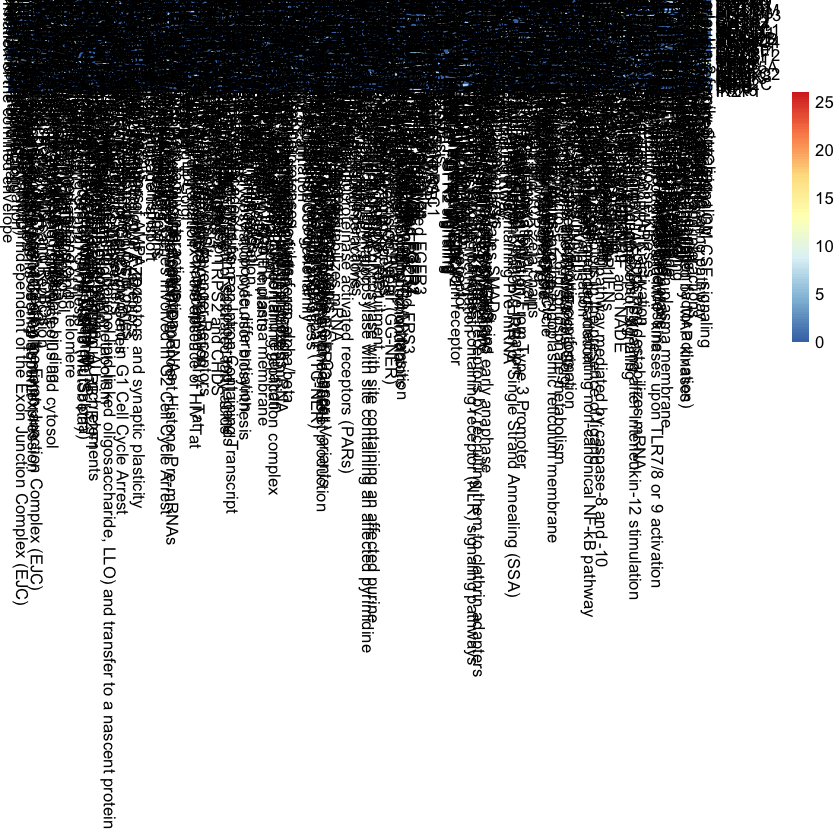

In [335]:
p_reactome = pheatmap(-log2(tf_by_reactome_pval_mean_highVarCol),
        cluster_rows=F)

save_pheatmap_pdf(p_reactome, paste0(save_prefix, 'tf_by_reactome_pval_mean_highVarCol.pdf'), width=50, height=20) 

In [138]:
# tf_by_reactome_pval_mean[select_tfs_post_enrich,]

In [139]:
tissue = 'GDSD6'
tissue_crm_file = paste0('../data/processed/tissue_crms/combined_tissue/',tissue,'_crm.csv')
tissue_crm_df = read.csv(tissue_crm_file,row.names=1)
head(tissue_crm_df)

tissue exp    num_loop_counts num_loops num_atac_regions AHR ARID5B
A1BG     GDSD6   2.445 38              2         0                0   0     
A1BG-AS1 GDSD6   0.095  0              0         0                0   0     
A1CF     GDSD6   0.000  0              0         0                0   0     
A2M      GDSD6   0.370  0              0         0                0   0     
A2M-AS1  GDSD6   0.010  0              0         0                0   0     
A2ML1    GDSD6  32.385 21              1         0                0   0     
         ARNT ARNTL ATF1 ⋯ ZNF384 ZNF394 ZNF436 ZNF467 ZNF528 ZNF554 ZNF563
A1BG     0    0     0    ⋯ 0      0      0      0      0      0      0     
A1BG-AS1 0    0     0    ⋯ 0      0      0      0      0      0      0     
A1CF     0    0     0    ⋯ 0      0      0      0      0      0      0     
A2M      0    0     0    ⋯ 0      0      0      0      0      0      0     
A2M-AS1  0    0     0    ⋯ 0      0      0      0      0      0      0     
A2ML1    0    0     0    ⋯ 0      0      0      0      0      0      0     
         ZNF680 ZNF768 ZNF770
A1BG     0      0      0     
A1BG-AS1 0      0      0     
A1CF     0      0      0     
A2M      0      0      0     
A2M-AS1  0      0      0     
A2ML1    0      0      0

In [140]:
length(select_genes)
tf = 'TP63'#select_genes[2] #PRDM1
tf

[1] 92

[1] "TP63"

In [141]:
tf %in% colnames(tissue_crm_df)

[1] TRUE

In [142]:
target_genes = rownames(tissue_crm_df)[tissue_crm_df[,tf]>0]
write.csv(target_genes,paste0(save_dir, tf,'_',tissue,'_target_genes.csv'))
target_genes_entrez = bitr(target_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
length(target_genes_entrez)

'select()' returned 1:1 mapping between keys and columns



[1] 268

In [148]:
ego <- enrichGO(gene          = target_genes_entrez,
                universe      = all_entrez,
                OrgDb         = org.Hs.eg.db,
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.2)#,
#         readable      = TRUE)
dim(ego)
head(ego)

[1] 6 9

ID         Description                         GeneRatio BgRatio  
GO:0008544 GO:0008544 epidermis development               23/248    464/17715
GO:0009913 GO:0009913 epidermal cell differentiation      20/248    358/17715
GO:0030216 GO:0030216 keratinocyte differentiation        16/248    305/17715
GO:0043588 GO:0043588 skin development                    19/248    419/17715
GO:0003334 GO:0003334 keratinocyte development            4/248     12/17715 
GO:0045682 GO:0045682 regulation of epidermis development 8/248     85/17715 
           pvalue       p.adjust     qvalue      
GO:0008544 1.669718e-07 0.0002916714 0.0002788078
GO:0009913 1.670034e-07 0.0002916714 0.0002788078
GO:0030216 6.631380e-06 0.0065356176 0.0062473756
GO:0043588 7.484246e-06 0.0065356176 0.0062473756
GO:0003334 1.698985e-05 0.0118691095 0.0113456432
GO:0045682 2.504803e-05 0.0145821286 0.0139390094
           geneID                                                                                                                       
GO:0008544 64919/51806/9620/1969/2317/9314/3860/3883/390792/3854/196374/220074/4097/4665/4851/4926/23022/5275/2810/81858/11005/11078/677
GO:0009913 64919/1969/2317/9314/3860/3883/390792/3854/196374/220074/4097/4851/4926/23022/5275/2810/81858/11005/11078/677                
GO:0030216 64919/1969/2317/3860/3883/390792/3854/196374/4851/4926/23022/5275/2810/81858/11005/677                                       
GO:0043588 10058/64919/9620/1969/2317/3860/3883/390792/3854/196374/4851/4926/23022/5275/2810/81858/10999/11005/677                      
GO:0003334 64919/2317/23022/2810                                                                                                        
GO:0045682 4097/4665/4851/4926/5275/2810/11005/677                                                                                      
           Count
GO:0008544 23   
GO:0009913 20   
GO:0030216 16   
GO:0043588 19   
GO:0003334  4   
GO:0045682  8

In [ ]:
er = enrichPathway(
    gene = target_genes_entrez, organism = "human", pvalueCutoff = 0.05, pAdjustMethod = "none", qvalueCutoff = 0.5, 
    universe = all_entrez,
    readable      = TRUE
)

In [ ]:
er_df = data.frame(er)
dim(er_df)
er_df$tf = tf
er_df$tissue = tissue
rownames(er_df) = NULL
head(er_df)

In [ ]:
dotplot(er)